# Clasificación con Red Neuronal Avanzada (TensorFlow)

## 1. Introducción

En este notebook construiremos una red neuronal avanzada (MLP) para clasificación multiclase.

Utilizamos BatchNormalization, Dropout y EarlyStopping para mejorar la generalización.

## 2. Preprocesamiento

In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1. Carga de datos

In [ ]:
file_id = '1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'train.csv', quiet=False)
df_train = pd.read_csv("train.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY
From (redirected): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY&confirm=t&uuid=a7dfd24c-3161-4068-974c-e4873e5176a5
To: /content/train.csv
100%|██████████| 144M/144M [00:00<00:00, 185MB/s]


In [ ]:
file_id_test = '1KrH-u4UU1e_Ha7cFuCZOB7ZT4tEUQ2ex'
gdown.download(f'https://drive.google.com/uc?id={file_id_test}', 'test.csv', quiet=False)
df_test = pd.read_csv("test.csv")

Downloading...
From: https://drive.google.com/uc?id=1KrH-u4UU1e_Ha7cFuCZOB7ZT4tEUQ2ex
To: /content/test.csv
100%|██████████| 59.2M/59.2M [00:00<00:00, 248MB/s]


### 2.2. Limpieza de datos (valores faltantes)

In [ ]:
if 'FAMI_TIENEINTERNET.1' in df_train.columns:
    df_train.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

missing_replacements = {
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Sin información',
    'ESTU_HORASSEMANATRABAJA': 'Sin información',
    'FAMI_ESTRATOVIVIENDA': 'Sin información',
    'FAMI_EDUCACIONPADRE': 'No sabe / No responde',
    'FAMI_EDUCACIONMADRE': 'No sabe / No responde',
    'FAMI_TIENECOMPUTADOR': 'Sin información',
    'FAMI_TIENEINTERNET': 'Sin información',
    'FAMI_TIENEAUTOMOVIL': 'Sin información'
}
for col, value in missing_replacements.items():
    df_train[col] = df_train[col].fillna(value)

mode_columns = ['FAMI_TIENELAVADORA', 'ESTU_PAGOMATRICULAPROPIO']
for col in mode_columns:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

### 2.3. Selección de features más relevantes para evitar sobrecarga

In [ ]:
selected_columns = [
    'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEAUTOMOVIL',
    'FAMI_TIENELAVADORA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
    'ESTU_HORASSEMANATRABAJA', 'ESTU_PAGOMATRICULAPROPIO'
]

X = df_train[selected_columns]
y = df_train['RENDIMIENTO_GLOBAL']

In [ ]:
# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True).astype(np.float32)

### 2.4. Codificación y escalado

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix

# Convertir a matriz dispersa para reducir el uso de memoria
X_sparse = csr_matrix(X.values)

# Escalar usando MaxAbsScaler (compatible con datos dispersos)
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_sparse)

In [ ]:
# División en conjuntos de entrenamiento y validación
X_train, X_val, y_train_raw, y_val_raw = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Codificación de etiquetas
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train_raw))
y_val = to_categorical(le.transform(y_val_raw))

## 3. Modelo de Machine Learning

### 3.1. Arquitectura de la red neuronal

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.2. Compilación y entrenamiento

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=1024,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4402 - loss: 1.1911 - val_accuracy: 0.4285 - val_loss: 1.2046 - learning_rate: 1.0000e-05
Epoch 2/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.4402 - loss: 1.1912 - val_accuracy: 0.4284 - val_loss: 1.2046 - learning_rate: 1.0000e-05
Epoch 3/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.4392 - loss: 1.1908 - val_accuracy: 0.4282 - val_loss: 1.2046 - learning_rate: 1.0000e-05
Epoch 4/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.4407 - loss: 1.1903 - val_accuracy: 0.4281 - val_loss: 1.2046 - learning_rate: 1.0000e-05
Epoch 5/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.4400 - loss: 1.1911 - val_accuracy: 0.4281 - val_loss: 1.2047 - learning_rate: 1.0000e-05
Epoch 6/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.4392 - loss: 1.1907 - val_accuracy: 0.4282 - val_loss: 1.2047 - learning_rate: 1.0000e-05


### 3.3. Evaluación final

In [ ]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("\n🎯 Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=le.classes_))

4329/4329 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step

🎯 Classification Report:
              precision    recall  f1-score   support

        alto       0.56      0.62      0.59     35165
        bajo       0.45      0.56      0.50     34573
  medio-alto       0.32      0.26      0.29     34259
  medio-bajo       0.32      0.27      0.29     34503

    accuracy                           0.43    138500
   macro avg       0.41      0.43      0.42    138500
weighted avg       0.41      0.43      0.42    138500



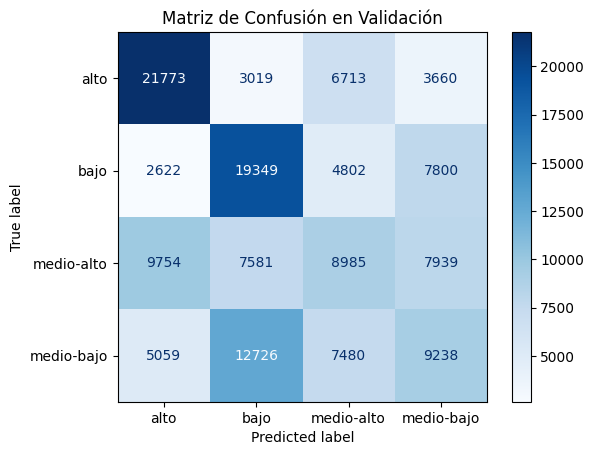

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión en Validación")
plt.grid(False)
plt.show()

## 4. Predicción y Exportación

### 4.1. Aplicar mismo preprocesamiento al test.csv

In [ ]:
# Asegurar que las columnas del conjunto de prueba coincidan con las del entrenamiento
X_test_kaggle = df_test[selected_columns]
X_test_kaggle = pd.get_dummies(X_test_kaggle, drop_first=True)
X_test_kaggle = X_test_kaggle.reindex(columns=X.columns, fill_value=0).astype(np.float32)

# Escalar los datos
X_test_kaggle_scaled = scaler.transform(X_test_kaggle)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MaxAbsScaler was fitted without feature names
  warnings.warn(


### 4.2. Realizar predicciones

In [ ]:
y_pred = model.predict(X_test_kaggle)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))

9275/9275 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


### 4.3. Visualización

/tmp/ipython-input-21-806410070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")


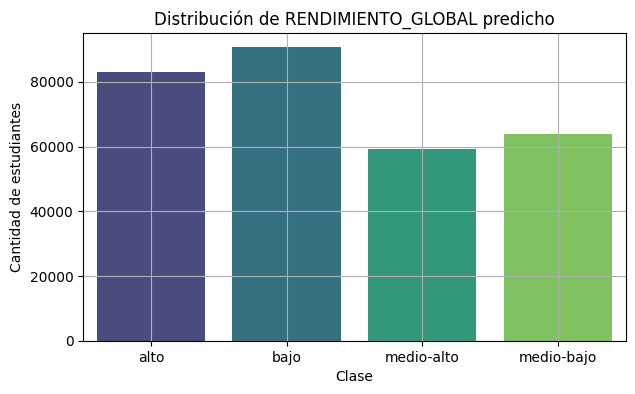

In [ ]:
pred_counts = pd.Series(y_pred_labels).value_counts().sort_index()
plt.figure(figsize=(7, 4))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")
plt.title("Distribución de RENDIMIENTO_GLOBAL predicho")
plt.xlabel("Clase")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True)
plt.show()

### 4.4. Envío a Kaggle

In [ ]:
submission = pd.DataFrame({
    'ID': df_test['ID'],
    'RENDIMIENTO_GLOBAL': y_pred_labels
})
submission.to_csv('submission_nn_avanzada.csv', index=False)
print("✅ Archivo 'submission_nn_avanzada.csv' generado")

✅ Archivo 'submission_nn_avanzada.csv' generado


## 5. Conclusiones

- Este modelo alcanzó un accuracy de 0.42644 en Kaggle, mostrando un gran avance frente a otros métodos anteriores.
- Se utilizaron técnicas avanzadas como Batch Normalization, Dropout, EarlyStopping y arquitectura profunda para mejorar el rendimiento sin sobrecargar la memoria.
- Aunque su ejecución es más lenta y sensible a la normalización de datos, logró captar patrones complejos, lo que demuestra el potencial de las redes neuronales en tareas de clasificación multiclase con gran volumen de datos.